In [1]:
import torch
import torch.utils.data as torchdata
import numpy as np
import datetime as dt

import jax
import jax.numpy as jnp

from flax import linen as nn

import os
import sys
sys.path.append("/project")

import model.hydro.gr4j_prod as t_prod
import model.hydro.gr4j_prod_flax as j_prod
from model.ml.cnn_flax import ConvNet
from model.utils.training import EarlyStopper
from model.utils.evaluation import evaluate, nse
from data.utils import read_dataset_from_file, get_station_list

In [2]:

from tqdm import tqdm

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax 

In [3]:
data_dir = '/data/camels/aus/'
sub_dir = 'no-scale'
station_id = '105105A'
run_dir = '/project/results/hygr4j'

x1_init = 0.530927
s_init = 0.0

window_size = 7
batch_size = 460
n_epoch = 250

in_channels = 1
n_features = 5
n_filters = (8, 8, 6)
dropout = 0.1

lr = 1e-4

In [4]:
print(f"Reading data for station_id: {station_id}")
train_ds, val_ds = read_dataset_from_file(data_dir, 
                                          sub_dir, 
                                          station_id=station_id)

Reading data for station_id: 105105A


In [5]:
if not os.path.exists(run_dir):
    os.makedirs(run_dir)

plot_dir = os.path.join(run_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

t_train, X_train, y_train = train_ds.tensors
t_val, X_val, y_val = val_ds.tensors

y_mu = y_train.mean(dim=0)
y_sigma = y_train.std(dim=0)

In [6]:
X_train = torch.nan_to_num(X_train)
X_val = torch.nan_to_num(X_val)


y_train = (y_train - y_mu)/y_sigma
y_val = (y_val - y_mu)/y_sigma


In [7]:
t_prod_store = t_prod.ProductionStorage(s_init=s_init, x1=x1_init)
t_x_out = t_prod_store(X_train, include_x=True)[0]

x_mu = t_x_out.mean(dim=0).numpy()
x_sigma = t_x_out.std(dim=0).numpy()

In [8]:
class HyGR4J(nn.Module):
    x1_init: float
    s_init: float
    x_mu: np.ndarray
    x_sigma: np.ndarray
    n_filters: tuple=(8, 8, 6)
    dropout_p: float=0.2
    window_size: int=7
    training: bool=True
    scale: float=1000.0

    def setup(self):
        self._prod_store = j_prod.ProductionStorage(x1_init=self.x1_init,
                                                   s_init=self.s_init,
                                                   scale=self.scale)
        self._model = ConvNet(n_filters=self.n_filters,
                              dropout_p=self.dropout_p,
                              training=self.training)
    
    def create_sequence(self, X, q):

        # Create empyty sequences
        Xs, ys = [], []

        # Add sequences to Xs and ys
        for i in range(1, len(X) - self.window_size):
            Xs.append(jnp.concatenate([
                                    X[i: (i + self.window_size)],
                                    q[i - 1:(i + self.window_size) - 1]
                                ], axis=1))

        Xs = jnp.stack(Xs)
        Xs = jnp.expand_dims(Xs, axis=3)

        return Xs

    
    def __call__(self, x, q):
        prod_out, s_store = self._prod_store(x)
        prod_out = (prod_out - x_mu)/x_sigma
        # prod_out = jnp.concatenate([prod_out, s_store.reshape(-1, 1)], axis=1)
        seq = self.create_sequence(prod_out, q)
        q_out = self._model(seq)
        return q_out, s_store[-1]
         


In [9]:
# Key Generators
root_key = jax.random.PRNGKey(seed=0)
main_key, params_key, dropout_key = jax.random.split(key=root_key, num=3)

In [10]:
hygr4j = HyGR4J(x1_init=x1_init, s_init=s_init, 
                n_filters=n_filters, dropout_p=dropout,
                x_mu=x_mu, x_sigma=x_sigma)


In [11]:
train_ds = torchdata.TensorDataset(X_train, y_train)
train_dl = torchdata.DataLoader(train_ds, batch_size=batch_size, 
                                shuffle=False, num_workers=2, prefetch_factor=2)

val_ds = torchdata.TensorDataset(X_val, y_val)
val_dl = torchdata.DataLoader(val_ds, batch_size=batch_size, 
                              shuffle=False, num_workers=2, prefetch_factor=2)

In [12]:
@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')

In [13]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    key: jax.random.KeyArray

def create_train_state(module, params_key, dropout_key, lr):
    """Creates an initial `TrainState`."""
    
    params = module.init({'params': params_key, 'dropout': dropout_key}, 
                     jax.random.normal(main_key, (batch_size, n_features)), 
                     jax.random.normal(main_key, (batch_size, 1)))['params']
    
    tx = optax.adamw(lr, b1=0.88, b2=0.96, weight_decay=0.03)

    return TrainState.create(apply_fn=module.apply, 
                             params=params, tx=tx,
                             key=dropout_key,
                             metrics=Metrics.empty())

In [14]:
@jax.jit
def train_step(state, dropout_key, batch, targets):
    """Train for a single step."""
    
    def loss_fn(params):
        preds, s_store = state.apply_fn({'params': params}, batch, targets,
                                rngs={'dropout': dropout_key})
        loss = optax.l2_loss(preds, targets[window_size+1:]).mean()
        return loss
    
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    return state

In [15]:
@jax.jit
def compute_metrics(*, state, dropout_key, batch, targets):
    
    preds, s_store = state.apply_fn({'params': state.params}, batch, targets,
                            rngs={'dropout': dropout_key})
    
    loss = optax.l2_loss(preds, targets[window_size+1:]).mean()
    
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    
    return state, s_store

In [16]:
state = create_train_state(hygr4j, params_key=params_key,
                           dropout_key=dropout_key, lr=lr)

In [17]:
metrics_history = {'train_loss': [],
                   'test_loss': []}

In [18]:
# Early stopping
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

In [19]:
pbar = tqdm(range(1, n_epoch+1))

for epoch in pbar:

    hygr4j.s_init = s_init
    hygr4j.training = True

    # Train step
    for step, (batch, targets) in enumerate(train_dl):

        batch = batch.detach().numpy()
        targets = targets.detach().numpy()

        state = train_step(state, dropout_key, batch, targets)
        state, s_store_train = compute_metrics(state=state, 
                                               dropout_key=dropout_key,
                                               batch=batch, targets=targets)
        hygr4j.s_init = s_store_train/(state.params['_prod_store']['x1']*hygr4j.scale)
    
    for metric, value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty())

    # Validation step
    test_state = state
    hygr4j.s_init = s_init
    hygr4j.training = False
    for step, (batch, targets) in enumerate(val_dl):
        batch = batch.detach().numpy()
        targets = targets.detach().numpy()
        test_state, s_store_test = compute_metrics(state=test_state, 
                                                   dropout_key=dropout_key,
                                                   batch=batch, targets=targets)
        hygr4j.s_init = s_store_test/(test_state.params['_prod_store']['x1']*hygr4j.scale)

    for metric, value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)
    
    pbar.set_description(f"""Epoch {epoch}/{n_epoch} loss: {metrics_history['train_loss'][-1]:.4f} val_loss: {metrics_history['test_loss'][-1]:.4f}""")

    if early_stopper.early_stop(metrics_history['test_loss'][-1]):
        break

Epoch 250/250 loss: 0.2355 val_loss: 0.2463: 100%|██████████| 250/250 [04:41<00:00,  1.13s/it]


In [26]:
y_mu_np = y_mu.detach().numpy()
y_sigma_np = y_sigma.detach().numpy()

# Empty list to store batch-wise tensors
Q = []
Q_hat = []

hygr4j.training = False
hygr4j.s_init = s_init

for i, (X, y) in enumerate(val_dl, start=1):

    X = X.detach().numpy()
    y = y.detach().numpy()
    
    y_hat, s_store = hygr4j.apply({'params': state.params}, X, y)
    hygr4j.s_init = s_store/(state.params['_prod_store']['x1']*hygr4j.scale)

    Q.append((y[window_size+1:]*y_sigma_np+y_mu_np))
    Q_hat.append((y_hat*y_sigma_np+y_mu_np))

Q = np.concatenate(Q, axis=0)
Q_hat = jnp.clip(np.concatenate(Q_hat, axis=0), 0)


In [27]:
import matplotlib.pyplot as plt

In [28]:
nse_score = nse(Q, Q_hat)
nse_score

0.6029231250286102

In [29]:
jnp.sqrt(jnp.mean(jnp.square(Q-Q_hat)))

DeviceArray(3.0190701, dtype=float32)

In [30]:
state.params['_prod_store']

FrozenDict({
    x1: DeviceArray([0.52806824], dtype=float32),
})

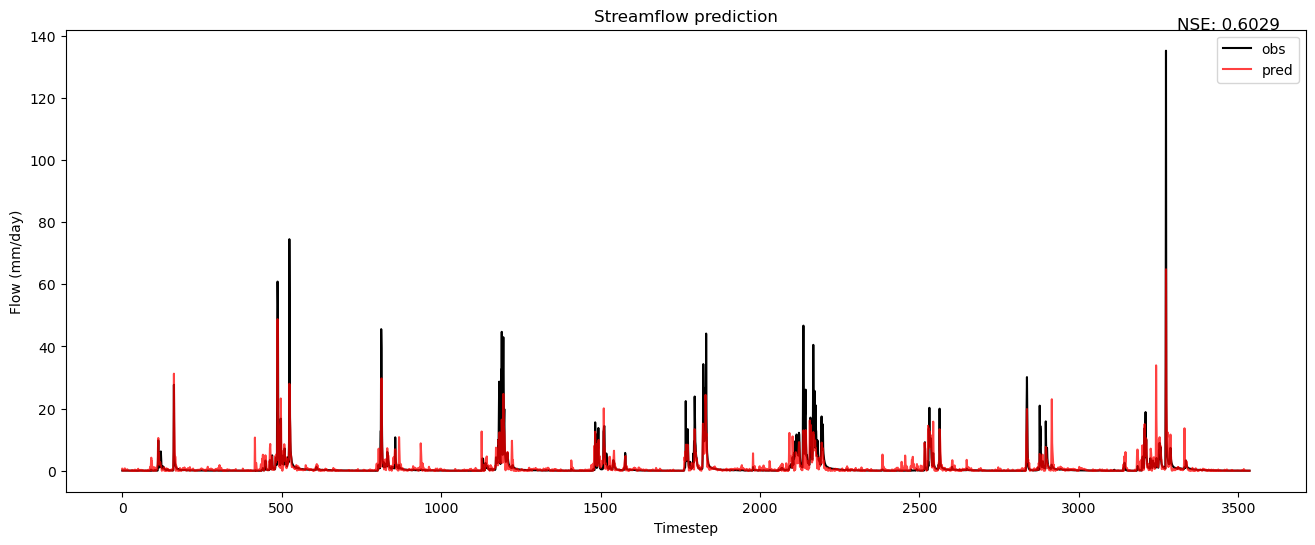

In [31]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(Q, color='black', label='obs', alpha=1.0)
ax.plot(Q_hat, color='red', label='pred', alpha=0.75)

ax.set_xlabel('Timestep')
ax.set_ylabel('Flow (mm/day)')

ax.annotate(f'NSE: {nse_score:.4f}',
        xy=(0.8, 0.88), xycoords='figure fraction',
        horizontalalignment='right', verticalalignment='top',
        fontsize=12)
ax.set_title('Streamflow prediction')

plt.legend()
